In [3]:
import torch, glob, os
import numpy as np
import matplotlib.image as mpimg
from class_snapbot import Snapbot4EnvClass, Snapbot3EnvClass
from class_policy_cvae import SnapbotTrajectoryUpdateClass
from class_grp import *
from utils import *

def eval_snapbot_from_network(env, dur_sec, n_anchor, max_repeat, folder, epoch,  condition, RENDER=False, PLOT=True):
    EvalPolicy = SnapbotTrajectoryUpdateClass(
                                                name = "Eval CVAE Trajectory",
                                                env  = env,
                                                out_min = -1.5,
                                                out_max = +1.5, 
                                                z_dim    = 32,
                                                c_dim    = 3,
                                                h_dims   = [128, 128],
                                                var_max  = 0.1,
                                                n_anchor = 20,
                                                dur_sec  = 2,
                                                max_repeat    = max_repeat,
                                                hyp_prior     = {'g': 1/1, 'l': 1/8, 'w': 1e-8},
                                                hyp_posterior = {'g': 1/2, 'l': 1/8, 'w': 1e-8},
                                                lbtw_base     = 0.8,
                                                device_idx = 0
                                                )
    ss_x_min  = -np.ones(env.adim)
    ss_x_max  = np.ones(env.adim)
    ss_margin = 0.1
    try:
        EvalPolicy.DLPG.load_state_dict(torch.load("dlpg/{}/weights/dlpg_model_weights_{}.pth".format(folder, epoch), map_location='cuda:0'))
    except:
        EvalPolicy.DLPG.load_state_dict(torch.load("dlpg/{}/weights/dlpg_model_weights_{}.pth".format(folder, epoch), map_location='cpu'))
    EvalPolicy.DLPG.eval()
    EvalPolicy.GRPPrior.set_prior(n_data_prior=4, dim=EvalPolicy.env.adim, dur_sec=dur_sec, HZ=EvalPolicy.env.hz, hyp=EvalPolicy.hyp_prior)
    traj_joints, traj_secs = EvalPolicy.GRPPrior.sample_one_traj(rand_type='Uniform', ORG_PERTURB=True, perturb_gain=0.0)
    t_anchor, _ = get_anchors_from_traj(traj_secs, traj_joints, n_anchor=EvalPolicy.n_anchor) 
    n_sample = 5
    for i in range(n_sample):
        x_anchor = EvalPolicy.DLPG.sample_x(c=torch.FloatTensor([0,1,0]).reshape(1,-1).to(EvalPolicy.device), n_sample=1, SKIP_Z_SAMPLE=True)[0].reshape(EvalPolicy.n_anchor, EvalPolicy.env.adim)
        x_anchor[-1,:] = x_anchor[0,:]
        EvalPolicy.GRPPosterior.set_posterior(t_anchor,x_anchor,lbtw=1.0,t_test=traj_secs,hyp=EvalPolicy.hyp_posterior,APPLY_EPSRU=True,t_eps=0.025)
        policy4eval_traj, traj_secs = EvalPolicy.GRPPosterior.sample_one_traj(rand_type='Uniform', ORG_PERTURB=True, perturb_gain=0.0, ss_x_min=ss_x_min,ss_x_max=ss_x_max,ss_margin=ss_margin)
        policy4eval_traj = scaleup_traj(EvalPolicy.env, policy4eval_traj, DO_SQUASH=True, squash_margin=5)
        t_anchor, x_anchor = get_anchors_from_traj(traj_secs, policy4eval_traj, n_anchor=EvalPolicy.n_anchor)  
        policy4eval  = rollout(EvalPolicy.env, EvalPolicy.PID, policy4eval_traj, n_traj_repeat=EvalPolicy.max_repeat, RENDER=RENDER, PLOT=PLOT)
        eval_reward  = sum(policy4eval['forward_rewards'])
        eval_x_diff  = policy4eval['x_diff']
        eval_secs    = policy4eval['secs']
        eval_figure  = policy4eval['figure']
        eval_xy_degs = policy4eval['xy_degs']
        # eval_figure.savefig('for_plot_{}'.format(i))
        # plt.close()
        plot_snapbot_joint_traj_and_topdown_traj(traj_secs, policy4eval_traj, t_anchor, x_anchor, eval_xy_degs, eval_secs,
                                                    figsize=(16,8), title_str="REWARD: {:>.1f} X_DIFF: {:>.3f}".format(eval_reward, eval_x_diff), 
                                                    tfs=15, SAVE=False, image_name=None)
        print("REWARD: {:>.1f} X_DIFF: {:>.3f}".format(eval_reward, eval_x_diff))
    return EvalPolicy

Snapbot(4legs) Environment
Obs Dim: [103] Act Dim: [8] dt:[0.02] Condition:[None]
ctrl_coef:[0] body_coef:[0] jump_coef:[0] vel_coef:[0] head_coef:[0]
Eval CVAE Trajectory START with DEVICE: cuda:0
REWARD: 72.2 X_DIFF: 1.444
REWARD: 75.3 X_DIFF: 1.506
REWARD: 75.0 X_DIFF: 1.500
REWARD: 71.0 X_DIFF: 1.419
REWARD: 65.9 X_DIFF: 1.317


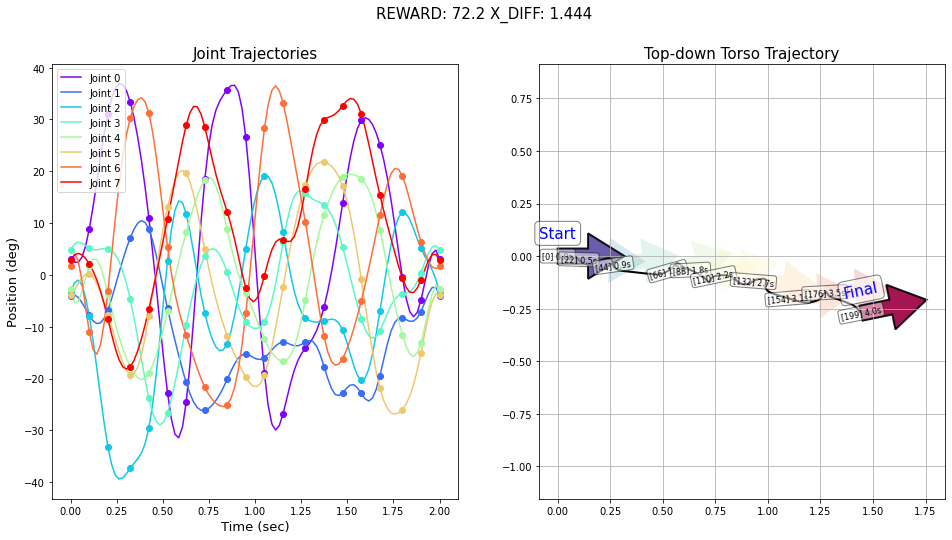

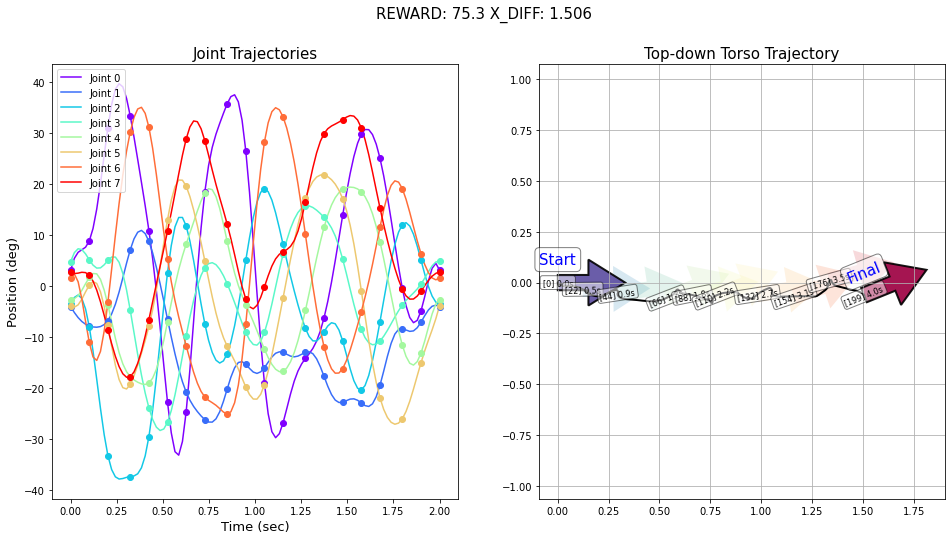

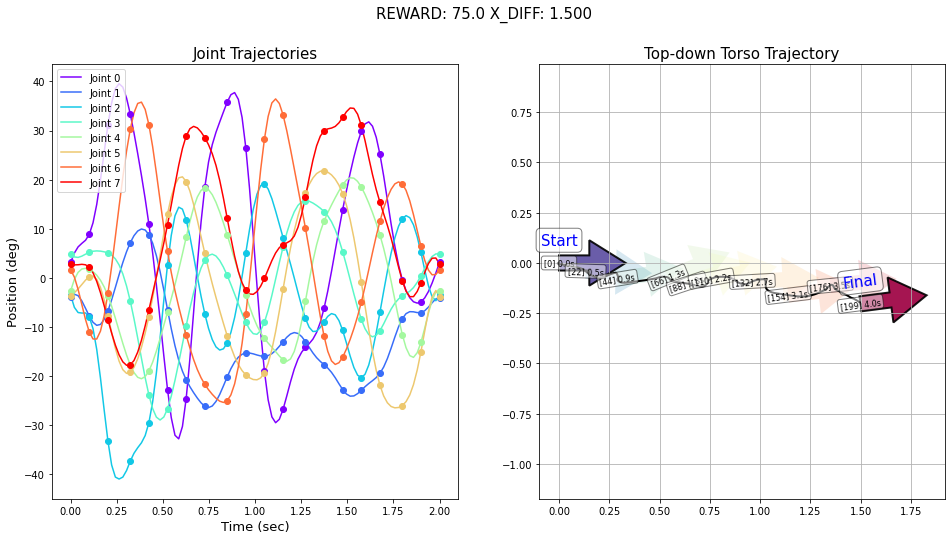

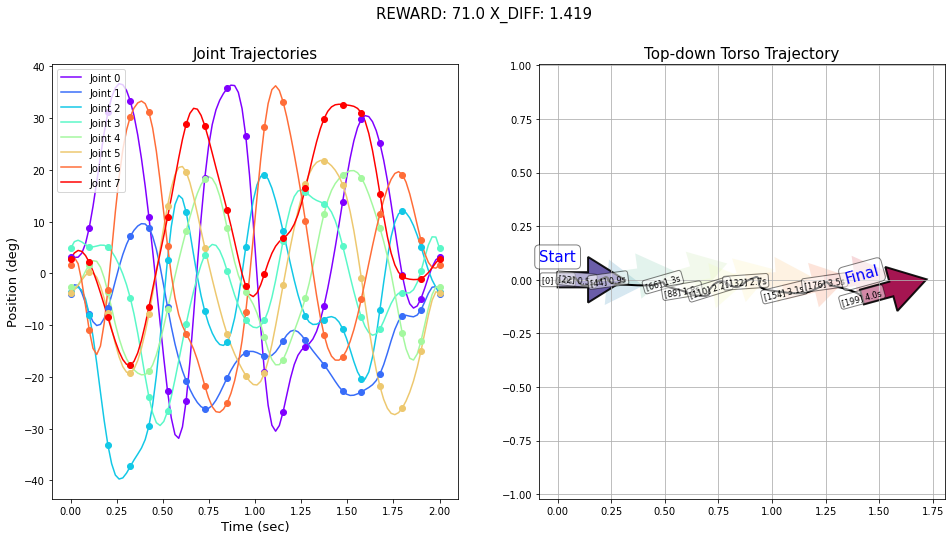

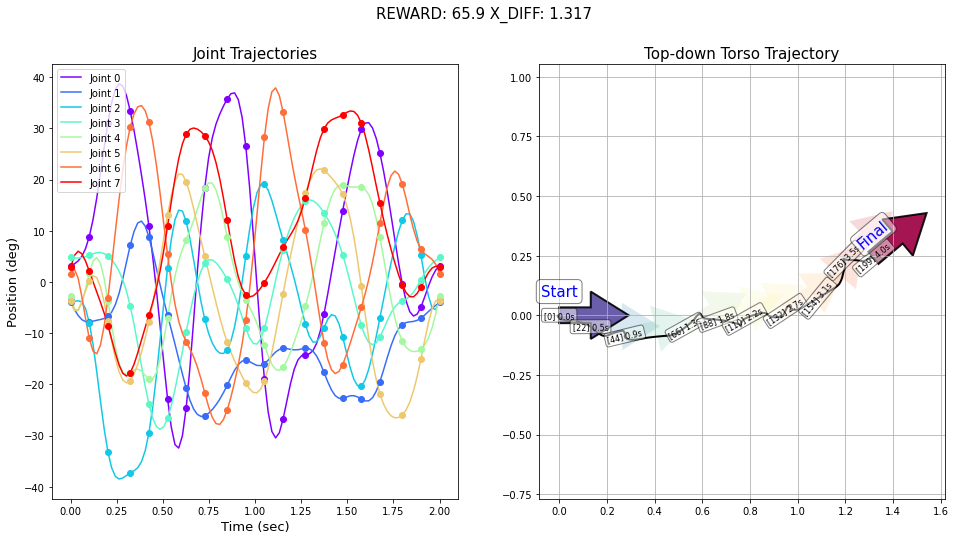

In [5]:
env = Snapbot4EnvClass(render_mode=None)
EVAL = eval_snapbot_from_network(env=env, dur_sec=2, n_anchor=20, max_repeat=2, folder=3, epoch=300,  condition=[0,1,0], RENDER=False, PLOT=False)